In [1]:
import operator
import sys
from functools import reduce
from typing import List, Tuple

import arviz as az
import daft
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Latex as lt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.funsor import config_enumerate, enum, infer_discrete
from numpyro.handlers import seed, trace
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs
from numpyro.infer.util import Predictive

In [2]:
#sys.path.append("..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from mbml_numpyro.chapter_02.plot import DisplaySkill, plot_inferred_true_skills
from mbml_numpyro.chapter_02.data import chapter_02_data

In [5]:
plt.rcParams["figure.dpi"] = 75
font = {"size": 18}
plt.rc("font", **font)

In [6]:
rng_key = jax.random.PRNGKey(2)
rng_key

DeviceArray([0, 2], dtype=uint32)

# Chapter 2
## Assessing People’s Skills
## 2.1 A model is a set of assumptions

**A model = A set of assumptions about the data**

#### Figure 2.2

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


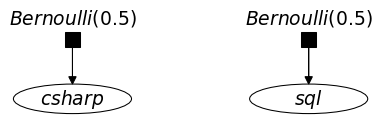

In [7]:
pgm = daft.PGM(node_ec="k",)
pgm.add_node(
    "csharp_param",
    r"$Bernoulli(0.5)$",
    0.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("csharp", r"$csharp$", 0.5, 1, aspect=4, label_params={"color": "k"})
pgm.add_node(
    "sql_param",
    r"$Bernoulli(0.5)$",
    4.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("sql", r"$sql$", 4.5, 1, aspect=4, label_params={"color": "k"})

pgm.add_edge("csharp_param", "csharp", plot_params={"head_width": 0.25,})
pgm.add_edge("sql_param", "sql", plot_params={"head_width": 0.25,})
pgm.render();

#### 2.1
$P\,(\texttt{csharp},\texttt{sql}) = \textrm{Bernoulli}(\texttt{csharp};0.5)\;\textrm{Bernoulli}(\texttt{csharp};0.5)$

#### Table 2.1

In [8]:
isCorrect1_cpt = np.array([[0.9, 0.1], [0.2, 0.8]])
pd.DataFrame(
    isCorrect1_cpt,
    columns=["isCorrect1=true", "isCorrect1=false"],
    index=["csharp=true", "csharp=false"],
)

,isCorrect1=true,isCorrect1=false
csharp=true,0.9,0.1
csharp=false,0.2,0.8


#### Figure 2.3

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/daft.py:842: RuntimeWarning: divide by zero encountered in double_scalars
  * np.abs(dy / dx)


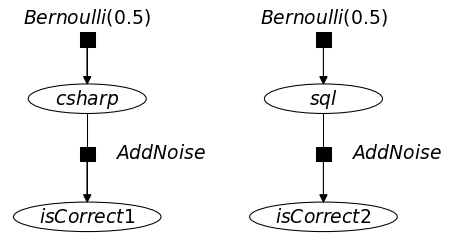

In [9]:
pgm = daft.PGM(node_ec="k",)
pgm.add_node(
    "csharp_param",
    r"$Bernoulli(0.5)$",
    0.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("csharp", r"$csharp$", 0.5, 1, aspect=4, label_params={"color": "k"})
pgm.add_node(
    "addnoise_param_00",
    r"$AddNoise$",
    0.5,
    0.0625,
    offset=(70, -10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "isCorrect1", r"$isCorrect1$", 0.5, -1, aspect=5, label_params={"color": "k"}
)

pgm.add_node(
    "sql_param",
    r"$Bernoulli(0.5)$",
    4.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("sql", r"$sql$", 4.5, 1, aspect=4, label_params={"color": "k"})
pgm.add_node(
    "addnoise_param_01",
    r"$AddNoise$",
    4.5,
    0.0625,
    offset=(70, -10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "isCorrect2", r"$isCorrect2$", 4.5, -1, aspect=5, label_params={"color": "k"}
)

pgm.add_edge("csharp_param", "csharp", plot_params={"head_width": 0.25,})
pgm.add_edge("csharp", "addnoise_param_00", directed=False)
pgm.add_edge("addnoise_param_00", "isCorrect1", plot_params={"head_width": 0.25,})

pgm.add_edge("sql_param", "sql", plot_params={"head_width": 0.25,})
pgm.add_edge("sql", "addnoise_param_01", directed=False)
pgm.add_edge("addnoise_param_01", "isCorrect2", plot_params={"head_width": 0.25,})

pgm.render();

#### 2.2
$P\,(\texttt{csharp},\texttt{sql},\texttt{isCorrect1},\texttt{isCorrect2}) = \textrm{Bernoulli}(\texttt{csharp};0.5)\;\textrm{Bernoulli}(\texttt{csharp};0.5)\; \textrm{AddNoise}(\texttt{isCorrect1}|\texttt{csharp})\; \textrm{AddNoise}(\texttt{isCorrect2}|\texttt{sql})$

#### Figure 2.4

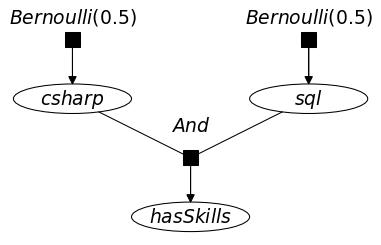

In [10]:
pgm = daft.PGM(node_ec="k",)
pgm.add_node(
    "csharp_param",
    r"$Bernoulli(0.5)$",
    0.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("csharp", r"$csharp$", 0.5, 1, aspect=4, label_params={"color": "k"})

pgm.add_node(
    "sql_param",
    r"$Bernoulli(0.5)$",
    4.5,
    2,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("sql", r"$sql$", 4.5, 1, aspect=4, label_params={"color": "k"})

pgm.add_node(
    "And_param",
    r"$And$",
    2.5,
    0,
    offset=(0.1, 20),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "hasSkills", r"$hasSkills$", 2.5, -1, aspect=4, label_params={"color": "k"}
)

pgm.add_edge("csharp_param", "csharp", plot_params={"head_width": 0.25,})
pgm.add_edge("sql_param", "sql", plot_params={"head_width": 0.25,})
pgm.add_edge("csharp", "And_param", directed=False)
pgm.add_edge("sql", "And_param", directed=False)
pgm.add_edge("And_param", "hasSkills", plot_params={"head_width": 0.25,})

pgm.render();

#### 2.3
$P\,(\texttt{csharp},\texttt{sql},\texttt{hasSkill}) = \textrm{Bernoulli}(\texttt{csharp};0.5)\;\textrm{Bernoulli}(\texttt{csharp};0.5)\; \textrm{And}(\texttt{hasSkill}|\texttt{csharp},\texttt{sql})$

#### Figure 2.5

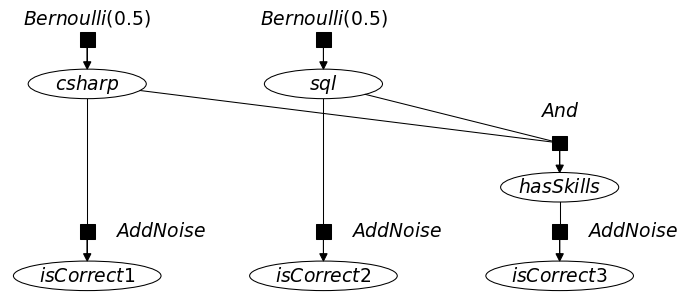

In [11]:
pgm = daft.PGM(node_ec="k",)
pgm.add_node(
    "csharp_param",
    r"$Bernoulli(0.5)$",
    0.5,
    3,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("csharp", r"$csharp$", 0.5, 2.25, aspect=4, label_params={"color": "k"})
pgm.add_node(
    "addnoise_param_00",
    r"$AddNoise$",
    0.5,
    -0.25,
    offset=(70, -10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "isCorrect1", r"$isCorrect1$", 0.5, -1, aspect=5, label_params={"color": "k"}
)

pgm.add_node(
    "sql_param",
    r"$Bernoulli(0.5)$",
    4.5,
    3,
    offset=(0.1, 10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node("sql", r"$sql$", 4.5, 2.25, aspect=4, label_params={"color": "k"})
pgm.add_node(
    "addnoise_param_01",
    r"$AddNoise$",
    4.5,
    -0.25,
    offset=(70, -10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "isCorrect2", r"$isCorrect2$", 4.5, -1, aspect=5, label_params={"color": "k"}
)


pgm.add_node(
    "And_param",
    r"$And$",
    8.5,
    1.25,
    offset=(0.1, 20),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "hasSkills", r"$hasSkills$", 8.5, 0.5, aspect=4, label_params={"color": "k"}
)
pgm.add_node(
    "addnoise_param_02",
    r"$AddNoise$",
    8.5,
    -0.25,
    offset=(70, -10),
    scale=3,
    fixed=True,
    shape="rectangle",
    label_params={"color": "k"},
)
pgm.add_node(
    "isCorrect3", r"$isCorrect3$", 8.5, -1, aspect=5, label_params={"color": "k"}
)

pgm.add_edge("csharp_param", "csharp", plot_params={"head_width": 0.25,})
pgm.add_edge("csharp", "addnoise_param_00", directed=False)
pgm.add_edge("addnoise_param_00", "isCorrect1", plot_params={"head_width": 0.25,})

pgm.add_edge("sql_param", "sql", plot_params={"head_width": 0.25,})
pgm.add_edge("sql", "addnoise_param_01", directed=False)
pgm.add_edge("addnoise_param_01", "isCorrect2", plot_params={"head_width": 0.25,})

pgm.add_edge("csharp", "And_param", directed=False)
pgm.add_edge("sql", "And_param", directed=False)
pgm.add_edge("And_param", "hasSkills", plot_params={"head_width": 0.25,})
pgm.add_edge("hasSkills", "addnoise_param_02", directed=False)
pgm.add_edge("addnoise_param_02", "isCorrect3", plot_params={"head_width": 0.25,})

pgm.render();

#### 2.4
$P\,(\texttt{csharp},\texttt{sql},\texttt{isCorrect1},\texttt{isCorrect2},\texttt{isCorrect3}) = \textrm{Bernoulli}(\texttt{csharp};0.5)\;\textrm{Bernoulli}(\texttt{csharp};0.5)\; \textrm{AddNoise}(\texttt{isCorrect1}|\texttt{csharp})\; \textrm{AddNoise}(\texttt{isCorrect2}|\texttt{sql})\; \textrm{And}(\texttt{hasSkill}|\texttt{csharp},\texttt{sql})\; \textrm{AddNoise}(\texttt{isCorrect3}|\texttt{hasSkills})$

## 2.2 Testing out the model

#### Table 2.4

In [12]:
expected = pd.DataFrame(
    [
        (False, False, False, 0.101, 0.101),
        (True, False, False, 0.802, 0.034),
        (False, True, False, 0.034, 0.802),
        (True, True, False, 0.561, 0.561),
        (False, False, True, 0.148, 0.148),
        (True, False, True, 0.862, 0.326),
        (False, True, True, 0.326, 0.862),
        (True, True, True, 0.946, 0.946),
    ],
    columns=["IsCorrect1", "IsCorrect2", "IsCorrect2", "P(cshapr)", "P(sql)"],
)
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(cshapr),P(sql)
0,False,False,False,0.101,0.101
1,True,False,False,0.802,0.034
2,False,True,False,0.034,0.802
3,True,True,False,0.561,0.561
4,False,False,True,0.148,0.148
5,True,False,True,0.862,0.326
6,False,True,True,0.326,0.862
7,True,True,True,0.946,0.946


In [13]:
responses_check = jnp.array(
    [
        [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
        [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0],
    ]
)
skills_needed_check = [[0], [1], [0, 1]]

In [14]:
def model_00(
    graded_responses, skills_needed: list[list[int]], prob_mistake=0.1, prob_guess=0.2
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

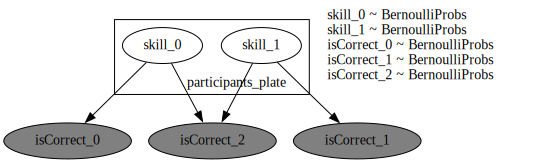

In [15]:
numpyro.render_model(
    model_00, (responses_check, skills_needed_check), render_distributions=True
)

In [16]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, responses_check, skills_needed_check)
mcmc.print_summary()

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:05<00:00, 215.89it/s, 1 steps of size 1.19e+37. acc. prob=1.00]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
skill_0[0]      0.10      0.31      0.00      0.00      1.00   5220.79      1.00
skill_0[1]      0.80      0.40      1.00      0.00      1.00   5336.51      1.00
skill_0[2]      0.03      0.18      0.00      0.00      0.00   4234.23      1.00
skill_0[3]      0.56      0.50      1.00      0.00      1.00   5173.84      1.00
skill_0[4]      0.15      0.36      0.00      0.00      1.00   5472.14      1.00
skill_0[5]      0.86      0.35      1.00      0.00      1.00   5602.83      1.00
skill_0[6]      0.32      0.47      0.00      0.00      1.00  10468.53      1.00
skill_0[7]      0.95      0.22      1.00      1.00      1.00   4502.64      1.00
skill_1[0]      0.10      0.30      0.00      0.00      1.00   4530.60      1.00
skill_1[1]      0.03      0.18      0.00      0.00      0.00   4251.81      1.00
skill_1[2]      0.81      0.39      1.00      0.00      1.00   6024.49      1.00
skill_1[3]      0.55      0

In [17]:
ds = az.from_numpyro(mcmc)

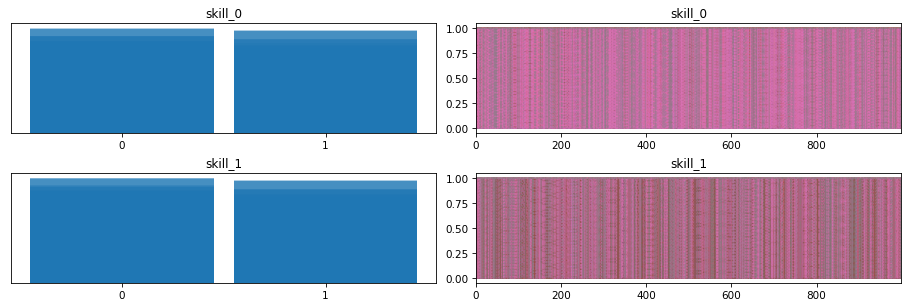

In [18]:
az.plot_trace(ds);

## 2.2 Testing out the model

In [19]:
four_skills_needed_check = skills_needed_check
four_skills_needed_check.append([0, 1])
four_skills_needed_check

[[0], [1], [0, 1], [0, 1]]

In [20]:
four_responses_check = jnp.array(
    [
        [0, 0, 0, 0,],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
    ]
)
four_responses_check = four_responses_check.T
four_responses_check

DeviceArray([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
             [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
             [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],            dtype=int32)

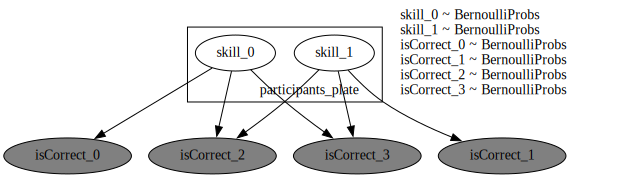

In [21]:
numpyro.render_model(
    model_00, (four_responses_check, four_skills_needed_check), render_distributions=True
)

In [22]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, four_responses_check, four_skills_needed_check)
mcmc.print_summary()

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:05<00:00, 208.34it/s, 1 steps of size 1.19e+37. acc. prob=1.00]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill_0[0]      0.10      0.30      0.00      0.00      0.00   4883.93      1.00
 skill_0[1]      0.11      0.31      0.00      0.00      1.00   4837.45      1.00
 skill_0[2]      0.10      0.30      0.00      0.00      1.00   5196.21      1.00
 skill_0[3]      0.30      0.46      0.00      0.00      1.00   2272.93      1.00
 skill_0[4]      0.02      0.14      0.00      0.00      0.00   4144.72      1.00
 skill_0[5]      0.07      0.26      0.00      0.00      0.00   4139.52      1.00
 skill_0[6]      0.07      0.26      0.00      0.00      0.00   4699.97      1.00
 skill_0[7]      0.68      0.47      1.00      0.00      1.00   7166.04      1.00
 skill_0[8]      0.80      0.40      1.00      0.00      1.00   4988.04      1.00
 skill_0[9]      0.82      0.39      1.00      0.00      1.00   6008.07      1.00
skill_0[10]      0.81      0.39      1.00      0.00      1.00   5757.09      1.00
skill_0[11]    

In [23]:
ds = az.from_numpyro(mcmc)

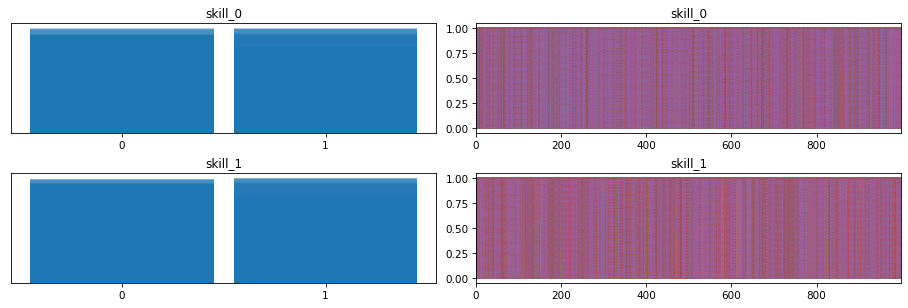

In [24]:
az.plot_trace(ds);

In [25]:
# with numpyro.handlers.seed(rng_seed=0):
#     print(enum(learning_skills)(example_data, example_skills_needed).shape)

## 2.4 Moving to real data 

In [26]:
chapter_02_data

ChapterData02.raw_data      | pd.DataFrame    shape= (23, 56)   raw data
ChapterData02.self_assessed | pd.DataFrame    shape= (22, 7)    self assessed skills from each participants
ChapterData02.skills_key    | pd.DataFrame    shape= (48, 7)    skills nesscary for each question as bool indicator, columns = n_skills, rows = n_questions
ChapterData02.skills_needed | List[List[int]] shape= 48         sparse version of skills_key
ChapterData02.responses     | pd.DataFrame    shape= (48, 22)   Graded responses, columns = n_participants, rows = n_questions

#### Table 2.6

In [27]:
chapter_02_data.raw_data

,#,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
0,ANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,...,2,1,5,4,2,5,2,2,2,1
1,P1,True,True,True,True,False,True,True,2,4,...,2,1,5,4,2,5,2,2,2,1
2,P2,True,True,True,True,False,False,True,1,4,...,5,1,1,4,3,3,4,4,3,1
3,P3,False,False,False,True,False,True,False,3,4,...,2,1,5,4,2,5,5,3,3,1
4,P4,True,True,False,True,False,False,False,2,4,...,2,5,5,4,2,5,4,2,3,1
5,P5,True,True,False,False,False,False,True,2,4,...,2,1,5,4,2,5,5,2,2,5
6,P6,False,False,False,False,False,False,False,1,3,...,4,4,4,2,4,3,1,5,1,3
7,P7,True,True,False,False,False,False,False,2,4,...,2,1,5,4,2,5,2,2,2,1
8,P8,True,True,False,False,False,False,True,2,4,...,2,5,5,4,2,5,4,2,2,1
9,P9,True,True,False,False,True,True,True,2,4,...,2,1,2,4,2,5,2,2,2,1


#### Figure 2.14

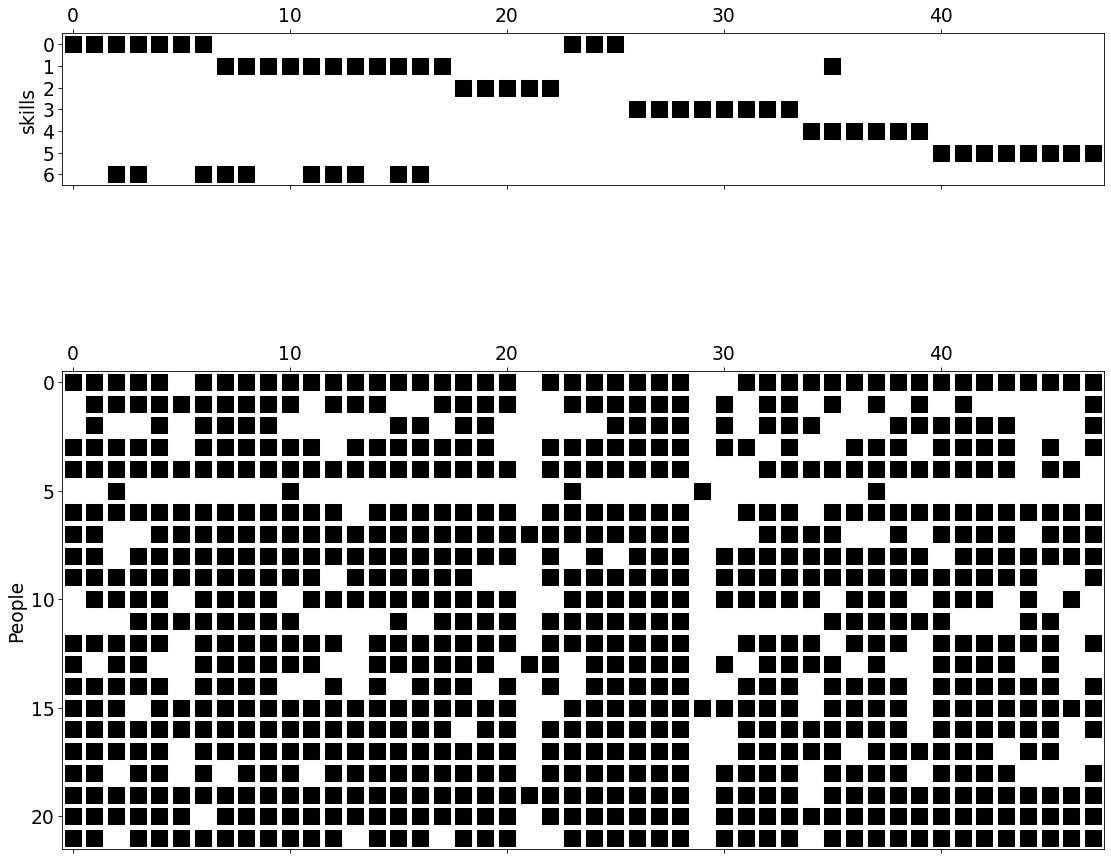

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].spy(chapter_02_data.skills_key.values.T, markersize=15, marker="s", color="k")
ax[0].set_ylabel("skills")
ax[1].spy(
    chapter_02_data.raw_data.loc[1:, "Q1":"Q48"]
    == chapter_02_data.raw_data.loc[0, "Q1":"Q48"],
    markersize=15,
    marker="s",
    color="k",
)
ax[1].set_ylabel("People")
plt.tight_layout()

#### Figure 2.15

In [29]:
color_skills = {str(i - 2): i for i in range(2, 8)}
color_skills["1,6"] = 8
color_skills["0,6"] = 9
color_skills["1,4"] = 10

second_skill = {6: "magenta", 4: "orange"}

In [30]:
figure_2pt15 = DisplaySkill(
    ListedColormap(
        [
            "white",
            "red",
            "orange",
            "yellow",
            "green",
            "cyan",
            "blue",
            "orange",
            "red",
            "cyan",
        ]
    ),
    color_skills,
    skills_needed=chapter_02_data.skills_needed,
    second_skill_color=second_skill,
    skill_legend=dict(
        red="Core",
        orange="OOP",
        yellow="Life Cycle",
        green="Web Apps",
        cyan="Desktop apps",
        blue="SQL",
        magenta="C#",
    ),
)

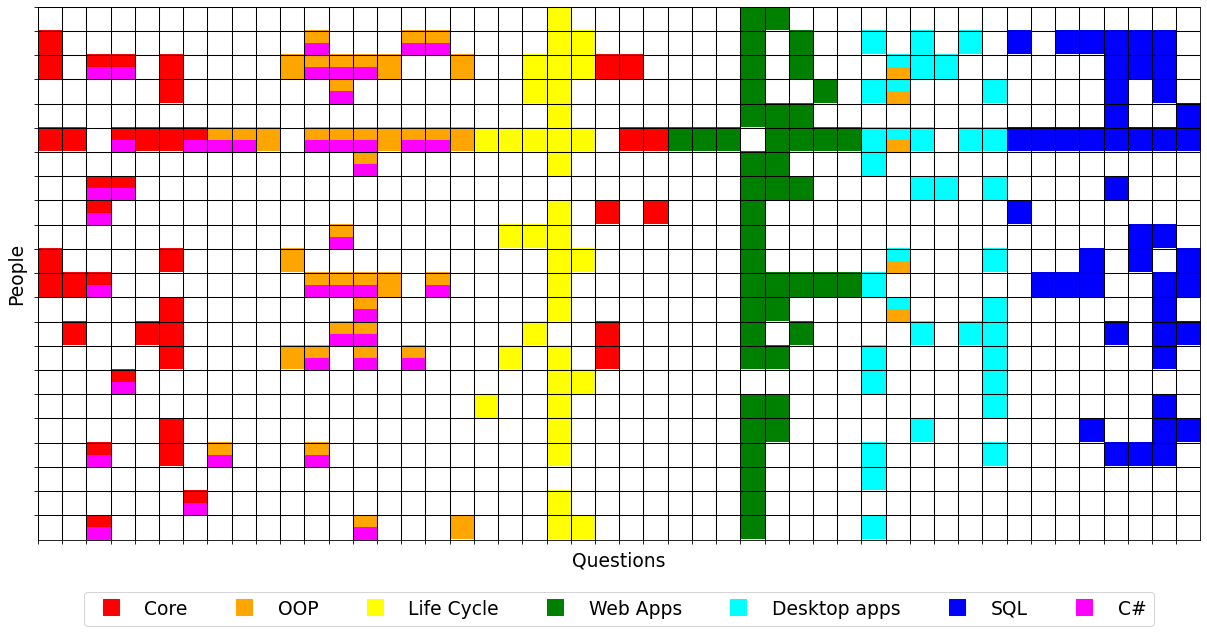

In [31]:
figure_2pt15.plot(chapter_02_data.responses.T)

#### Figure 2.17

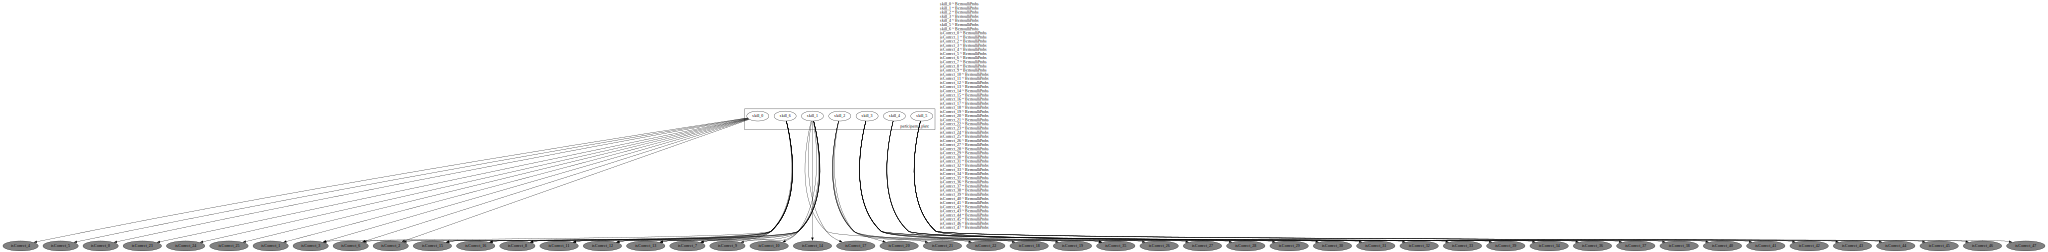

In [32]:
numpyro.render_model(
    model_00,
    (
        jnp.array(chapter_02_data.responses),
        chapter_02_data.skills_needed,
    ),
    render_distributions=True,
)

In [33]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed)
mcmc.print_summary()

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:46<00:00, 11.23it/s, 1 steps of size 1.19e+37. acc. prob=1.00]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill_0[0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[2]      0.01      0.10      0.00      0.00      0.00   4093.80      1.00
 skill_0[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[4]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[5]      0.00      0.00      0.00      0.00      0.00       nan       nan
 skill_0[6]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[7]      1.00      0.02      1.00      1.00      1.00       nan      1.00
 skill_0[8]      0.99      0.12      1.00      1.00      1.00   4130.52      1.00
 skill_0[9]      1.00      0.00      1.00      1.00      1.00       nan       nan
skill_0[10]      1.00      0.02      1.00      1.00      1.00       nan      1.00
skill_0[11]    

In [34]:
ds = az.from_numpyro(mcmc)

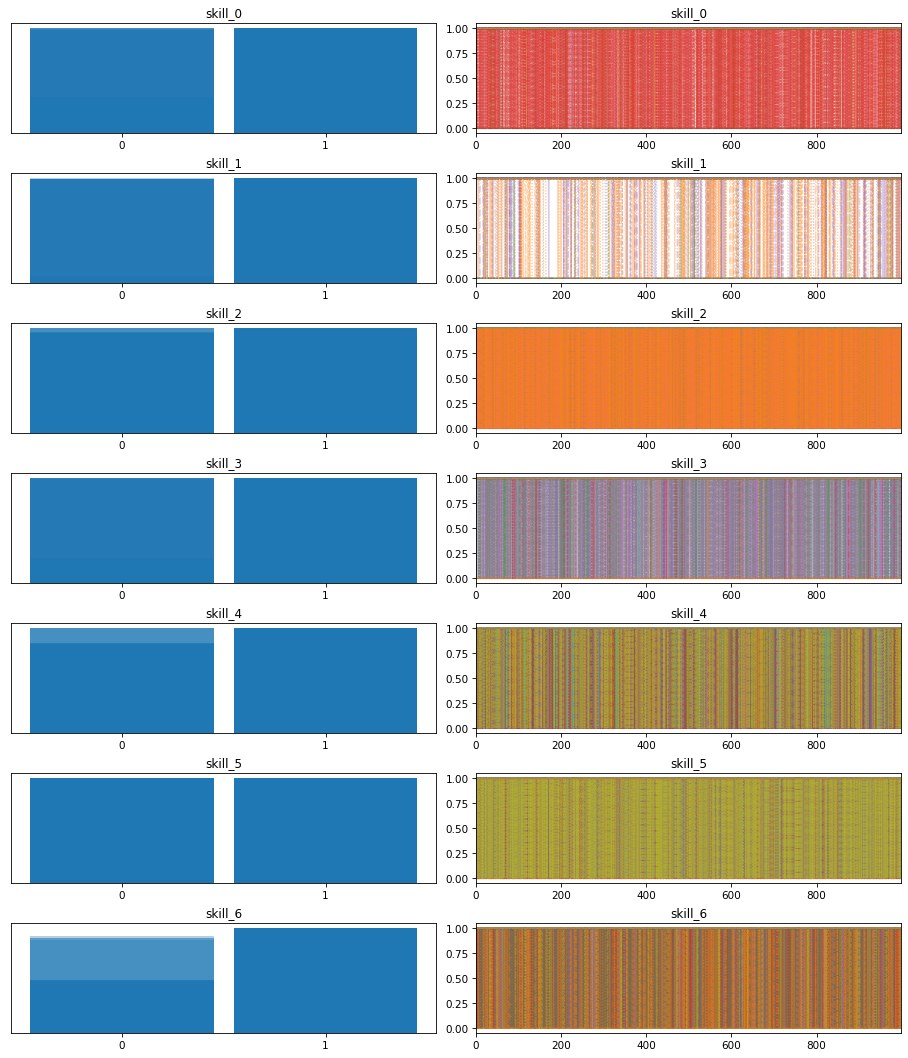

In [35]:
az.plot_trace(ds);

In [36]:
az.mcse(ds)

<xarray.Dataset>
Dimensions:        (skill_0_dim_0: 22, skill_1_dim_0: 22, skill_2_dim_0: 22, skill_3_dim_0: 22, skill_4_dim_0: 22, skill_5_dim_0: 22, skill_6_dim_0: 22)
Coordinates:
  * skill_0_dim_0  (skill_0_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_1_dim_0  (skill_1_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_2_dim_0  (skill_2_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_3_dim_0  (skill_3_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_4_dim_0  (skill_4_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_5_dim_0  (skill_5_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_6_dim_0  (skill_6_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
Data variables:
    skill_0        (skill_0_dim_0) float64 0.0 0.0 0.00161 0.0 ... 0.0 0.0 0.0
    skill_1        (skill_1_dim_0) float64 0.0 0.001052 0.001179 ... 0.0 0.0 0.0
    skill_2        (skill_2_dim_0) float64 0.00225 0.0041 ... 0.002053 0.004107
    skill_3        (skill_3_dim_0) float64 0.001331 0.001284 ... 0.0 0.0
    skill_4        (skill_4_dim_0) float64 0.0003527 0.004612 ... 0.0009612
    skill_5        (skill_5_dim_0) float64 0.0 0.0 0.004917 ... 0.0 0.0 0.0
    skill_6        (skill_6_dim_0) float64 0.0 0.001563 ... 0.0 0.0002495

In [37]:
az.rhat(ds)

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:        (skill_0_dim_0: 22, skill_1_dim_0: 22, skill_2_dim_0: 22, skill_3_dim_0: 22, skill_4_dim_0: 22, skill_5_dim_0: 22, skill_6_dim_0: 22)
Coordinates:
  * skill_0_dim_0  (skill_0_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_1_dim_0  (skill_1_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_2_dim_0  (skill_2_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_3_dim_0  (skill_3_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_4_dim_0  (skill_4_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_5_dim_0  (skill_5_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_6_dim_0  (skill_6_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
Data variables:
    skill_0        (skill_0_dim_0) float64 nan nan 1.0 nan ... nan nan nan nan
    skill_1        (skill_1_dim_0) float64 nan 0.9997 1.0 nan ... nan nan nan
    skill_2        (skill_2_dim_0) float64 0.9999 0.9994 ... 0.9999 0.9991
    skill_3        (skill_3_dim_0) float64 1.0 1.0 0.9996 1.0 ... 1.0 nan nan
    skill_4        (skill_4_dim_0) float64 0.9999 0.9994 0.9993 ... 1.0 0.9998
    skill_5        (skill_5_dim_0) float64 nan nan 0.9994 0.9996 ... nan nan nan
    skill_6        (skill_6_dim_0) float64 nan 0.9993 0.999 nan ... nan nan 1.0

In [38]:
az.ess(ds)

<xarray.Dataset>
Dimensions:        (skill_0_dim_0: 22, skill_1_dim_0: 22, skill_2_dim_0: 22, skill_3_dim_0: 22, skill_4_dim_0: 22, skill_5_dim_0: 22, skill_6_dim_0: 22)
Coordinates:
  * skill_0_dim_0  (skill_0_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_1_dim_0  (skill_1_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_2_dim_0  (skill_2_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_3_dim_0  (skill_3_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_4_dim_0  (skill_4_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_5_dim_0  (skill_5_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
  * skill_6_dim_0  (skill_6_dim_0) int64 0 1 2 3 4 5 6 ... 15 16 17 18 19 20 21
Data variables:
    skill_0        (skill_0_dim_0) float64 4e+03 4e+03 4.103e+03 ... 4e+03 4e+03
    skill_1        (skill_1_dim_0) float64 4e+03 4.051e+03 ... 4e+03 4e+03
    skill_2        (skill_2_dim_0) float64 4.202e+03 1.441e+04 ... 1.441e+04
    skill_3        (skill_3_dim_0) float64 3.924e+03 4.069e+03 ... 4e+03 4e+03
    skill_4        (skill_4_dim_0) float64 4.018e+03 5.914e+03 ... 4.045e+03
    skill_5        (skill_5_dim_0) float64 4e+03 4e+03 7.129e+03 ... 4e+03 4e+03
    skill_6        (skill_6_dim_0) float64 4e+03 4.056e+03 ... 4e+03 4.016e+03

In [39]:
inferred_skills_model_00 = np.array(
    jnp.vstack([value.mean(0) for value in mcmc.get_samples().values()]).T
)

In [40]:
from numpyro.infer import log_likelihood
from jax.scipy.special import logsumexp

In [41]:
from numpyro.infer.util import log_density, potential_energy

In [42]:
log_density_model_00 = log_density(model_00, (jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed), dict(prob_mistake=0.1, prob_guess=0.2), mcmc.get_samples())

In [43]:
log_density_model_00[0]

DeviceArray(-2474509.8, dtype=float32)

In [44]:
ll_model_00 = log_likelihood(model_00, mcmc.get_samples(), jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed)

In [45]:
ll_model_00

{'isCorrect_0': DeviceArray([ -9.145174,  -9.145174, -10.649252, ..., -10.649252,
               -9.145174,  -9.145174], dtype=float32),
 'isCorrect_1': DeviceArray([-8.334243 , -8.334243 , -6.2547994, ..., -6.2547994,
              -8.334243 , -8.334243 ], dtype=float32),
 'isCorrect_10': DeviceArray([-8.334243, -8.334243, -8.334243, ..., -8.334243, -8.334243,
              -9.838321], dtype=float32),
 'isCorrect_11': DeviceArray([-9.262955, -9.262955, -9.262955, ..., -9.262955, -9.262955,
              -9.262955], dtype=float32),
 'isCorrect_12': DeviceArray([-9.262957, -9.262957, -9.262957, ..., -9.262957, -9.262957,
              -9.262957], dtype=float32),
 'isCorrect_13': DeviceArray([-13.657405, -13.657405, -13.657405, ..., -13.657405,
              -13.657405, -13.657405], dtype=float32),
 'isCorrect_14': DeviceArray([-4.750722 , -4.750722 , -4.750722 , ..., -4.750722 ,
              -4.750722 , -2.6712809], dtype=float32),
 'isCorrect_15': DeviceArray([-9.838321, -9.838321, -9

#### Figure 2.18

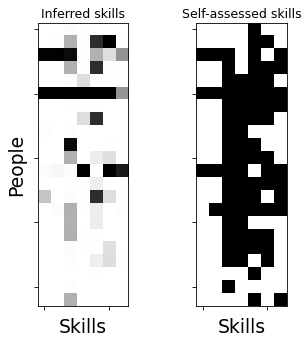

In [46]:
plot_inferred_true_skills(
    inferred_skills_model_00,
    chapter_02_data.self_assessed.values.astype("int32"),
    titles=("Inferred skills", "Self-assessed skills"),
    fontdict=dict(fontsize=12)
)

## 2.5 Diagnosing the problem

### Checking the inference algorithm

In [47]:
def model_01(
    skills_needed: list[list[int]],
    graded_responses=None,
    self_skills=None,
    prob_mistake=0.1,
    prob_guess=0.2,
    size_as: tuple[int, int] = (48, 22),
):
    n_questions, n_participants = (
        graded_responses.shape if graded_responses is not None else size_as
    )
    if graded_responses is None:
        graded_responses = [None] * n_questions
    n_skills = max(map(max, skills_needed)) + 1

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skill_obs = None if self_skills is None else self_skills[s]
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5), obs=skill_obs))

    has_skills_as = []
    isCorrect_as = []
    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        has_skills_as.append(has_skills)
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )
        isCorrect_as.append(isCorrect)

    return skills, has_skills_as, isCorrect_as

#### Ancestral sampling

In [48]:
with numpyro.handlers.seed(rng_seed=0):
    s = model_01(chapter_02_data.skills_needed)

In [49]:
skills_as, has_skills_as, isCorrect_as = s
skills_as = jnp.vstack(skills_as)
has_skills_as = jnp.vstack(has_skills_as)
isCorrect_as = jnp.vstack(isCorrect_as)

#### Figure 2.19

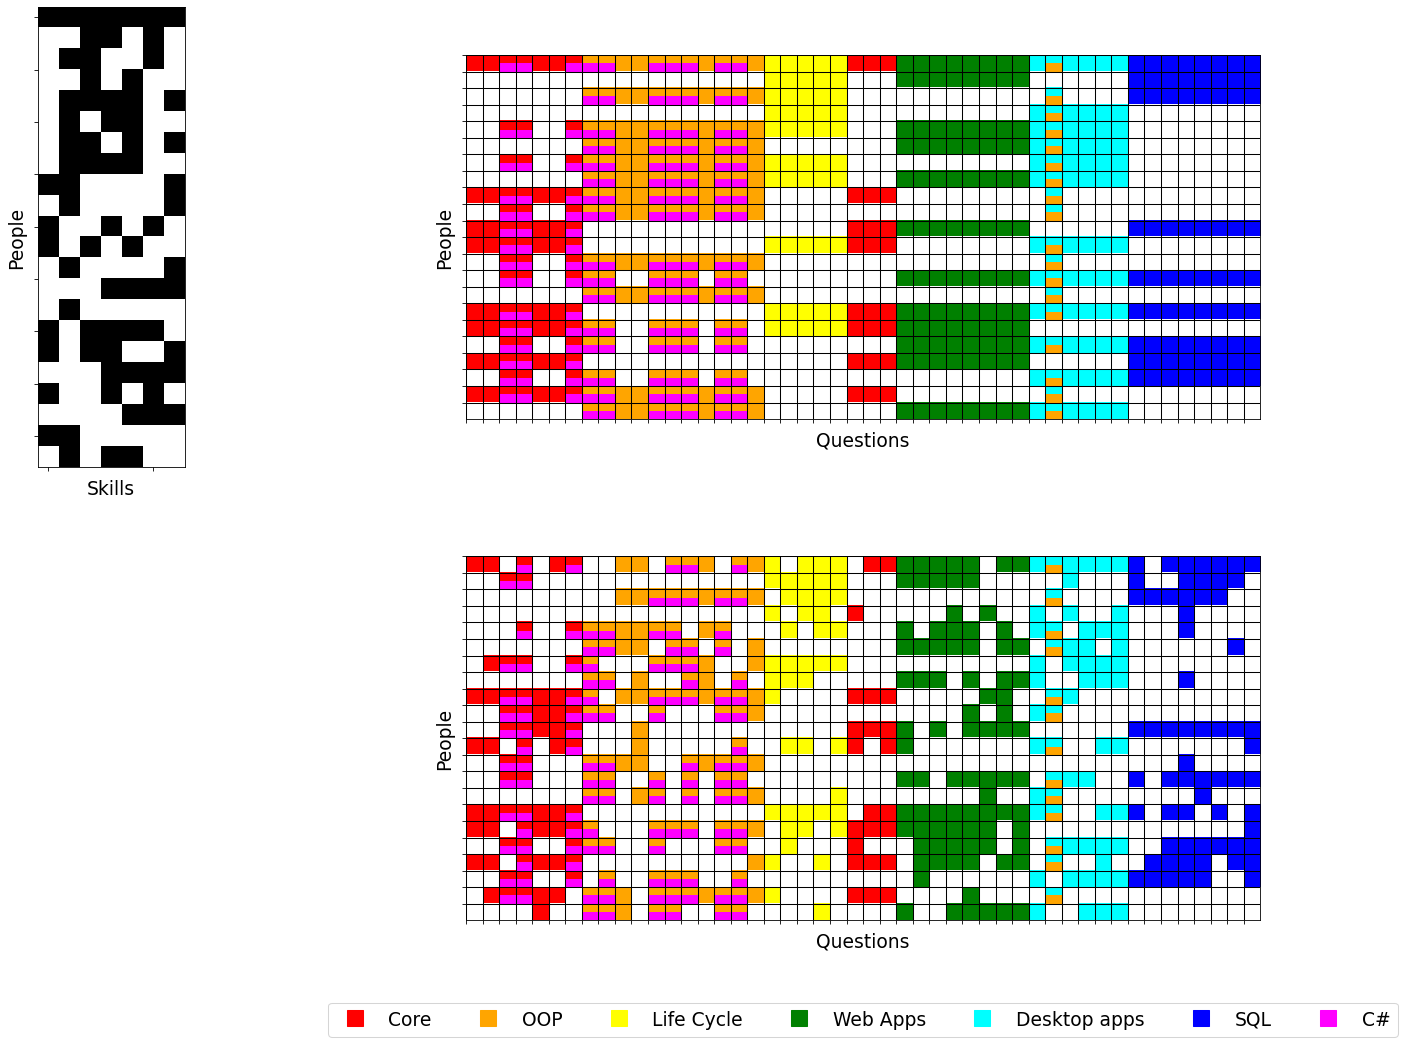

In [50]:
fig_2pt19 = plt.figure(constrained_layout=True, figsize=(20,20));

gs = fig_2pt19.add_gridspec(nrows=3, ncols=3)
fig_2pt19_ax1 = fig_2pt19.add_subplot(gs[0, 0])
fig_2pt19_ax2 = fig_2pt19.add_subplot(gs[0, 1:])
fig_2pt19_ax3 = fig_2pt19.add_subplot(gs[1, 1:])

fig_2pt19_ax1.imshow(skills_as.T, cmap="Greys_r")
fig_2pt19_ax1.set_aspect("equal");
fig_2pt19_ax1.set_ylabel("People");
fig_2pt19_ax1.set_xlabel("Skills");
fig_2pt19_ax1.set(yticklabels=[]);
fig_2pt19_ax1.set(xticklabels=[]);

figure_2pt15.plot(pd.DataFrame(has_skills_as.T), ax=fig_2pt19_ax2, plot_legend=False)

figure_2pt15.plot(pd.DataFrame(isCorrect_as.T), ax=fig_2pt19_ax3, bbox_to_anchor=(0.5, -0.2))

In [51]:
nuts_kernel = NUTS(model_00)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, isCorrect_as, chapter_02_data.skills_needed)
mcmc.print_summary()

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:49<00:00, 11.00it/s, 1 steps of size 1.18e+37. acc. prob=1.00]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 skill_0[0]      0.00      0.02      0.00      0.00      0.00       nan      1.00
 skill_0[1]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[2]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[3]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[4]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[5]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[6]      1.00      0.04      1.00      1.00      1.00   4021.89      1.00
 skill_0[7]      1.00      0.00      1.00      1.00      1.00       nan       nan
 skill_0[8]      0.00      0.00      0.00      0.00      0.00       nan       nan
 skill_0[9]      0.95      0.21      1.00      1.00      1.00   2028.11      1.00
skill_0[10]      0.00      0.00      0.00      0.00      0.00       nan       nan
skill_0[11]    

In [52]:
inferred_skills_from_as = np.array(
    jnp.vstack([value.mean(0) for value in mcmc.get_samples().values()]).T
)

#### Figure 2.20

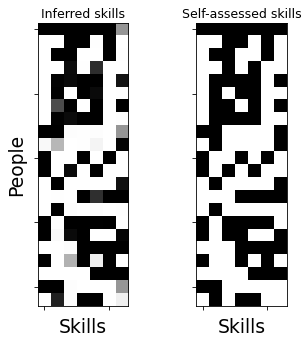

In [53]:
plot_inferred_true_skills(
    inferred_skills_from_as,
    skills_as.T,
    titles=("Inferred skills", "Self-assessed skills"),
    fontdict=dict(fontsize=12)
)

### Working out what is wrong with the model

In [54]:
with numpyro.handlers.seed(rng_seed=0):
    s = model_01(chapter_02_data.skills_needed, self_skills=chapter_02_data.self_assessed.astype(int).T.values)

In [55]:
skills_as, has_skills_as, isCorrect_as = s
skills_as = jnp.vstack(skills_as)
has_skills_as = jnp.vstack(has_skills_as)
isCorrect_as = jnp.vstack(isCorrect_as)

#### Figure 2.21

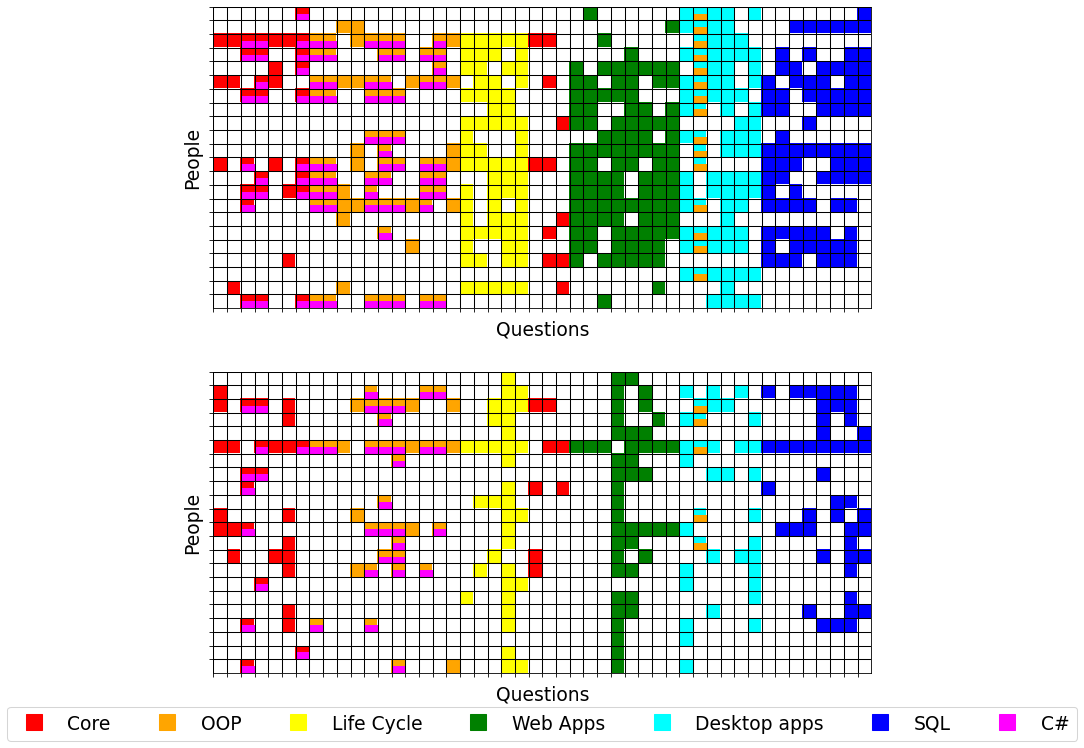

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
fig.tight_layout()

figure_2pt15.plot(pd.DataFrame(isCorrect_as.T), ax=ax[0], plot_legend=False)

figure_2pt15.plot(chapter_02_data.responses.T, ax=ax[1])

#### Figure 2.22

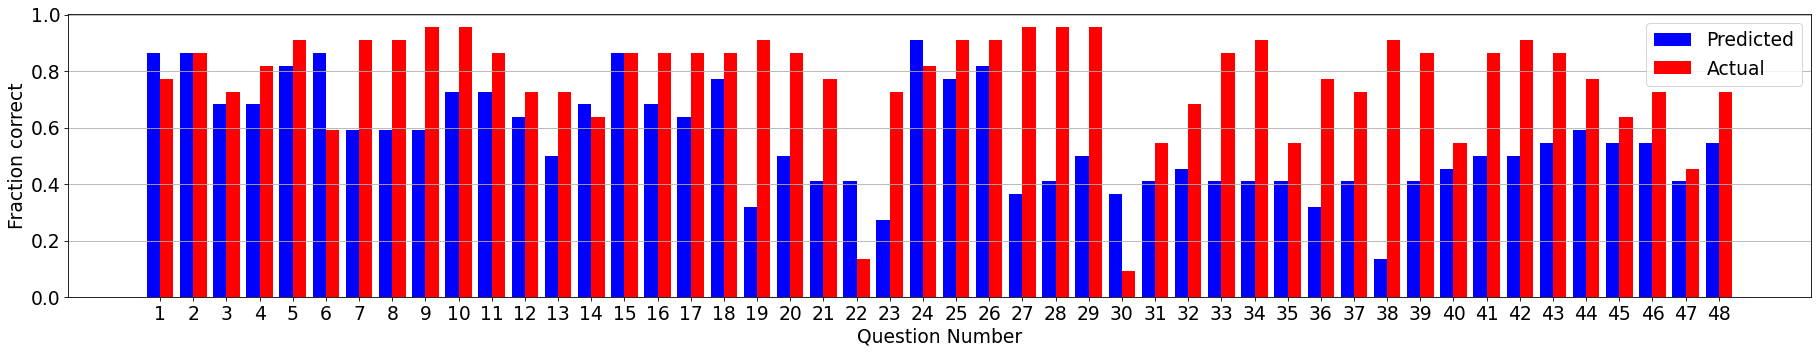

In [57]:
ind = np.arange(chapter_02_data.responses.shape[0])
width = 0.4

fig, ax = plt.subplots(figsize=(30,5))
ax.bar(ind, isCorrect_as.T.mean(0), width, label="Predicted", color="b")
ax.bar(ind + width, chapter_02_data.responses.mean(1).values, width, label="Actual", color="r")

ax.set_xlabel("Question Number")
ax.set_ylabel("Fraction correct")

plt.xticks(ind + width / 2, map(str, ind + 1))
plt.legend(loc='best')
plt.grid(axis="y")
plt.show()

## 2.6 Learning the guess probabilities

In [58]:
def model_02(
    graded_responses, skills_needed: list[list[int]], prob_mistake=0.1,
):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    with numpyro.plate("questions_plate", n_questions):
        prob_guess = numpyro.sample("prob_guess", dist.Beta(2.5, 7.5))

    participants_plate = numpyro.plate("participants_plate", n_participants)

    with participants_plate:
        skills = []
        for s in range(n_skills):
            skills.append(numpyro.sample("skill_{}".format(s), dist.Bernoulli(0.5)))

    for q in range(n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]])
        prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess[q]
        isCorrect = numpyro.sample(
            "isCorrect_{}".format(q),
            dist.Bernoulli(prob_correct).to_event(1),
            obs=graded_responses[q],
        )

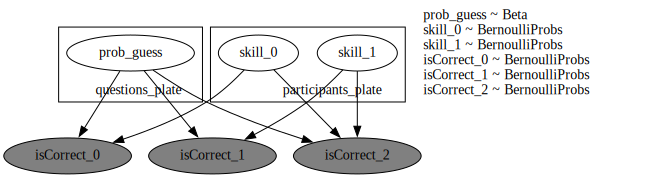

In [59]:
numpyro.render_model(
    model_02, (responses_check, skills_needed_check), render_distributions=True
)

In [60]:
nuts_kernel = NUTS(model_02)

kernel = DiscreteHMCGibbs(nuts_kernel, modified=True)

mcmc = MCMC(kernel, num_warmup=200, num_samples=1000, num_chains=4)
mcmc.run(rng_key, jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed)
mcmc.print_summary()

/home/benda/anaconda3/envs/mbml_numpyro/lib/python3.9/site-packages/numpyro/infer/mcmc.py:269: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  warnings.warn(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [02:15<00:00,  8.85it/s, 7 steps of size 4.65e-01. acc. prob=0.84]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
 prob_guess[0]      0.26      0.12      0.24      0.05      0.43   4018.62      1.00
 prob_guess[1]      0.28      0.12      0.27      0.07      0.46   4985.69      1.00
 prob_guess[2]      0.32      0.12      0.31      0.12      0.52   5196.04      1.00
 prob_guess[3]      0.33      0.13      0.32      0.11      0.53   3749.15      1.00
 prob_guess[4]      0.29      0.12      0.28      0.08      0.47   5087.65      1.00
 prob_guess[5]      0.20      0.11      0.19      0.03      0.37   4913.97      1.00
 prob_guess[6]      0.40      0.13      0.39      0.18      0.60   4370.26      1.00
 prob_guess[7]      0.38      0.13      0.37      0.17      0.60   5587.07      1.00
 prob_guess[8]      0.39      0.13      0.38      0.16      0.59   3703.78      1.00
 prob_guess[9]      0.32      0.13      0.31      0.10      0.52   4171.06      1.00
prob_guess[10]      0.30      0.13      0.29      0.10      0.50

In [61]:
ds = az.from_numpyro(mcmc)

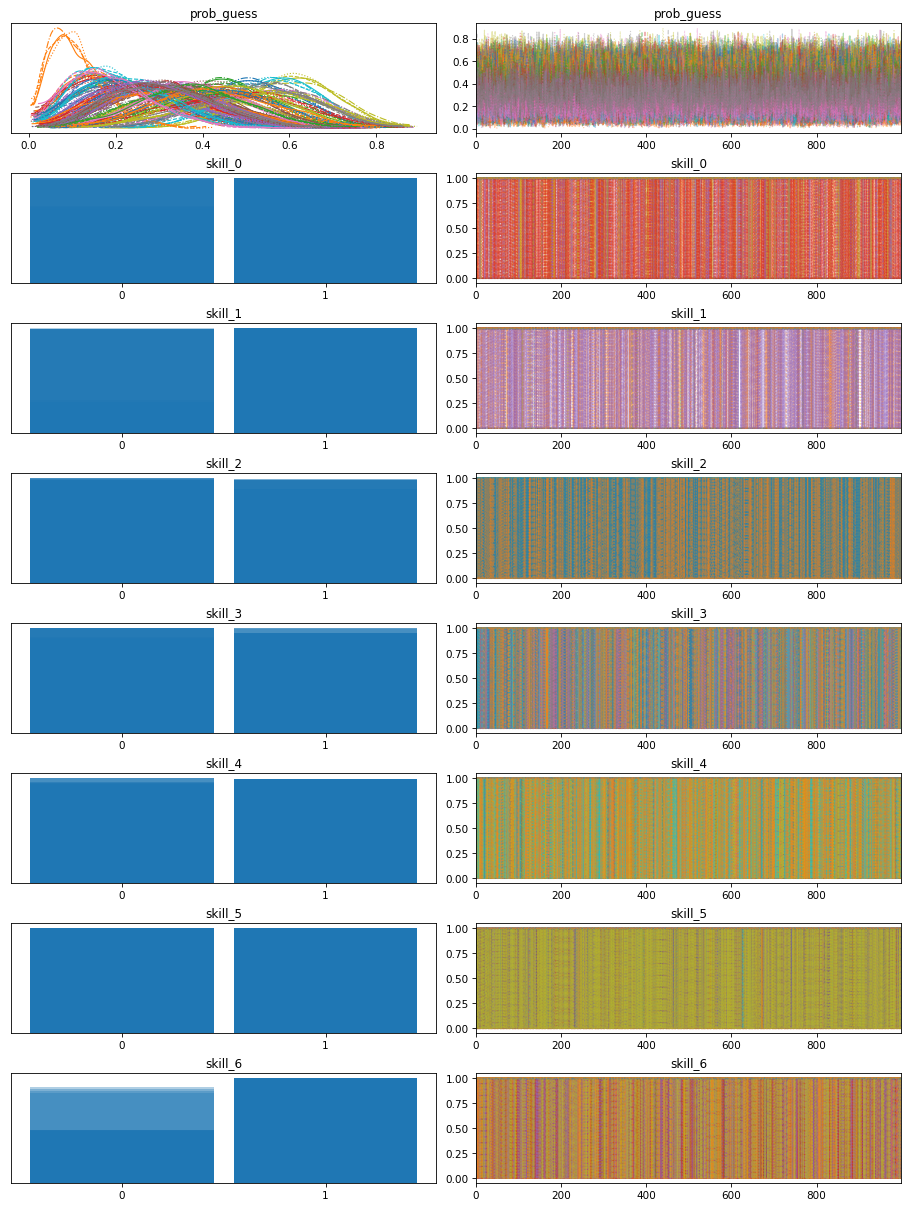

In [62]:
az.plot_trace(ds);

In [63]:
mcmc.get_samples()

{'prob_guess': DeviceArray([[0.3725071 , 0.21817861, 0.3740711 , ..., 0.17904304,
               0.2017616 , 0.32692078],
              [0.2933887 , 0.40840998, 0.24032938, ..., 0.3966786 ,
               0.2605172 , 0.33814353],
              [0.2521022 , 0.13045144, 0.35920686, ..., 0.51141   ,
               0.15149856, 0.15504055],
              ...,
              [0.39088508, 0.11587858, 0.15236267, ..., 0.41921136,
               0.05948563, 0.4134809 ],
              [0.26895112, 0.2194084 , 0.22282654, ..., 0.20605962,
               0.10718654, 0.26840726],
              [0.27430466, 0.2408133 , 0.22332151, ..., 0.36807415,
               0.06598815, 0.28047514]], dtype=float32),
 'skill_0': DeviceArray([[1, 1, 0, ..., 1, 1, 1],
              [1, 1, 0, ..., 1, 1, 1],
              [1, 1, 0, ..., 1, 1, 1],
              ...,
              [1, 1, 0, ..., 1, 1, 1],
              [1, 1, 0, ..., 1, 1, 1],
              [1, 1, 0, ..., 1, 1, 1]], dtype=int32),
 'skill_1': DeviceArray

In [64]:
inferred_skills_model_02 = np.array(
    jnp.vstack([value.mean(0) for value in list(mcmc.get_samples().values())[1:]]).T
)

In [65]:
log_density_model_00 = log_density(model_00, (jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed), dict(prob_mistake=0.1, prob_guess=0.2), mcmc.get_samples())

In [66]:
log_density_model_02 = log_density(model_02, (jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed), dict(prob_mistake=0.1), mcmc.get_samples())

ValueError: Incompatible shapes for broadcasting: ((4000, 22), (1, 48))

In [ ]:
ll_model_02 = log_likelihood(model_02, mcmc.get_samples(), jnp.array(chapter_02_data.responses), chapter_02_data.skills_needed)

In [ ]:
ll_model_02

In [ ]:
plot_inferred_true_skills(
    inferred_skills_model_02,
    chapter_02_data.self_assessed.values.astype("int32"),
    titles=("Inferred skills", "Self-assessed skills"),
    fontdict=dict(fontsize=12)
)

In [ ]:
import seaborn as sns

In [ ]:
iris = sns.load_dataset("iris")
iris

In [ ]:
np.array(mcmc.get_samples()["prob_guess"])[:, slice(0,-1,5)].shape

In [ ]:
np.array(mcmc.get_samples()["prob_guess"])[:, 0:-1:5].shape

In [ ]:
sns.kdeplot(data=np.array(mcmc.get_samples()["prob_guess"])[:, 0:-1:5])

In [ ]:
mcmc.get_samples()["prob_guess"]

In [ ]:
ds.posterior.data_vars["prob_guess"].shape

In [ ]:
np.array(mcmc.get_samples()["prob_guess"].mean(0))

In [ ]:
np.array(mcmc.get_samples()["prob_guess"].std(0))

In [ ]:
np.quantile(np.array(mcmc.get_samples()["prob_guess"]), q=0.5, axis=0)

In [ ]:
ax.errorbar(ind, np.array(mcmc.get_samples()["prob_guess"].mean(0)), yerr=np.array(mcmc.get_samples()["prob_guess"].std(0)), label="Predicted", color="b")

In [ ]:
(np.percentile(np.array(mcmc.get_samples()["prob_guess"]), q=25, axis=0), np.percentile(np.array(mcmc.get_samples()["prob_guess"]), q=75, axis=0))

In [ ]:
ind = np.arange(1,49)

fig, ax = plt.subplots(figsize=(30,5))
ax.bar(ind, np.array(mcmc.get_samples()["prob_guess"].mean(0)), label="Predicted", color="b")
ax.errorbar(ind, np.array(mcmc.get_samples()["prob_guess"].mean(0)), yerr=(np.percentile(np.array(mcmc.get_samples()["prob_guess"]), q=25, axis=0), np.percentile(np.array(mcmc.get_samples()["prob_guess"]), q=75, axis=0)), label="Predicted", color="k", fmt="o", capsize=5, capthick=2)
ax.grid(axis="y")
ax.set_xticks(range(1,49));
ax.set_xlim((0,49))

# [1::2] means start from the second element in the list and get every other element
for tick in ax.xaxis.get_major_ticks()[1::2]:
    tick.set_pad(20)

In [ ]:
az.plot_forest(
    {
        "prob_guess": mcmc.get_samples()["prob_guess"].T,
    }
);